<a href="https://colab.research.google.com/github/FXtest2023/FXtest2023/blob/main/0214_addcorr_USDJPY_News12H_maxdepth5_v3_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=20f7b8d2debdf4e817ede4ade40adcd3e58fa4c72d06da2ddae5bc1607662dee
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


In [2]:

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as pd_ta
from sklearn.model_selection import KFold
from optuna.integration import lightgbm as lgb
#import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
import random

In [3]:
currencypair = 'USDJPY'
market1 = 'US'
currency1 = 'USD'
market2 = 'JP'
currency2 = 'JPY'
news_freq = '12H'

In [4]:
url = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/main/" + currencypair + "_1D.csv"
df_price = pd.read_csv(url)

In [5]:
df_price['diff']  = df_price['bid_close'].shift(-1) - df_price['bid_close']
df_price['label'] = df_price['diff'].apply(lambda x: 1 if x>0 else 0 )
df_price.dropna(inplace=True)
df_price.reset_index(drop=True,inplace=True)

In [6]:
news_url1 = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/main/" + market1 + "_market_news_"+ news_freq +".csv"
df_news1 =  pd.read_csv(news_url1)

In [7]:
news_url2 = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/main/" + market2 + "_market_news_"+ news_freq +".csv"
df_news2 =  pd.read_csv(news_url2)

In [8]:
currency_news_url1 = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/main/" + currency1 + "_currency_news_"+ news_freq +".csv"
df_currency_news1 =  pd.read_csv(currency_news_url1)

In [9]:
currency_news_url2 = "https://raw.githubusercontent.com/FXtest2023/FXtest2023/main/" + currency2 + "_currency_news_"+ news_freq +".csv"
df_currency_news2 =  pd.read_csv(currency_news_url2)

In [10]:
df_1H = df_price.merge(df_news1, how='inner', on='utc_datetime')
df_1H = df_1H.merge(df_news2, how='inner', on='utc_datetime')

df_1H = df_1H.merge(df_currency_news1, how='inner', on='utc_datetime')
df_1H = df_1H.merge(df_currency_news2, how='inner', on='utc_datetime')


In [11]:
df_1H = df_1H.loc[df_1H.utc_datetime >'2019'][df_1H.utc_datetime <'2023-11']
df_1H

utc_datetime  bid_open  bid_high  bid_low  bid_close  \
0     2019-01-02 00:00:00+00:00   109.651   109.714  109.596    109.657   
1     2019-01-03 00:00:00+00:00   109.656   109.666  105.247    107.414   
2     2019-01-04 00:00:00+00:00   107.414   108.294  106.728    107.836   
3     2019-01-05 00:00:00+00:00   107.836   108.573  107.500    108.434   
4     2019-01-07 00:00:00+00:00   108.508   108.609  108.338    108.534   
...                         ...       ...       ...      ...        ...   
1504  2023-10-26 00:00:00+00:00   149.833   150.293  149.772    150.072   
1505  2023-10-27 00:00:00+00:00   150.072   150.754  149.843    150.343   
1506  2023-10-28 00:00:00+00:00   150.343   150.390  149.437    149.534   
1507  2023-10-30 00:00:00+00:00   149.525   149.749  149.525    149.712   
1508  2023-10-31 00:00:00+00:00   149.710   149.832  148.781    149.073   

       diff  label  stockindexbuzz_x  bondbuzz_x  ratesbuzz_x  ...  \
0    -2.243      0            3050.9       522.9        537.5  ...   
1     0.422      1           17279.8      3779.7       1132.5  ...   
2     0.598      1           14619.2      4854.9       1589.0  ...   
3     0.100      1           16348.4      4141.9       6010.0  ...   
4     0.078      1            2710.7       712.5        777.5  ...   
...     ...    ...               ...         ...          ...  ...   
1504  0.271      1           19199.4      9489.7       2961.0  ...   
1505 -0.809      0           22564.3      7402.1       3551.5  ...   
1506  0.178      1           20389.8      5511.9       4384.0  ...   
1507 -0.639      0            6527.6      3625.2       1763.5  ...   
1508  2.225      1           17844.8      8479.6       4972.5  ...   

      emotionvsfact_y  marketrisk_y  longshort_y  longshortfrcst_y  \
0              0.5000        0.0000       0.0000            0.0000   
1             -0.0206        0.0967       0.0017           -0.0007   
2              0.1691        0.0714       0.0011           -0.0003   
3              0.1519        0.0582      -0.0007           -0.0007   
4              0.1081        0.0513       0.0116            0.0000   
...               ...           ...          ...               ...   
1504           0.2957        0.0164       0.0031           -0.0000   
1505           0.3163       -0.0098      -0.0097            0.0003   
1506           0.3131        0.0222      -0.0026           -0.0011   
1507           0.1966        0.0173       0.0173            0.0007   
1508           0.1767        0.1071       0.0066            0.0004   

      pricedirection_y  priceforecast_y  volatility_y  carrytrade_y  \
0              -0.2500           0.0000        0.0000        0.0000   
1               0.1742           0.0072        0.0686        0.0003   
2               0.0974           0.0009        0.0892        0.0005   
3               0.1100           0.0201        0.0498        0.0000   
4               0.0724           0.0087        0.1223        0.0058   
...                ...              ...           ...           ...   
1504           -0.0313           0.0151        0.0396        0.0007   
1505           -0.0406           0.0041        0.0350        0.0019   
1506            0.0408          -0.0011        0.0235        0.0000   
1507            0.0249           0.0000        0.0168        0.0000   
1508            0.1198           0.0128        0.0429        0.0004   

      curpeginstablty_y  pricemomentum_y  
0                0.0000           0.0000  
1                0.0000           0.0624  
2                0.0000           0.0229  
3                0.0000           0.0222  
4                0.0000           0.0087  
...                 ...              ...  
1504             0.0000          -0.0003  
1505             0.0000          -0.0006  
1506            -0.0011           0.0016  
1507             0.0000           0.0007  
1508             0.0000           0.0120  

[1509 rows x 117 columns]

In [12]:

print(list(df_1H.columns))

['utc_datetime', 'bid_open', 'bid_high', 'bid_low', 'bid_close', 'diff', 'label', 'stockindexbuzz_x', 'bondbuzz_x', 'ratesbuzz_x', 'stkidxsentiment_x', 'stkidxoptimism_x', 'sidxtrust_x', 'sidxfear_x', 'sidxstress_x', 'sidxsurprise_x', 'sidxuncertainty_x', 'sidxmarketrisk_x', 'sidxprcdirection_x', 'sidxpricefrcst_x', 'sidxvolatility_x', 'bsentiment_x', 'boptimism_x', 'btrust_x', 'bfear_x', 'bstress_x', 'bsurprise_x', 'buncertainty_x', 'bdefault_x', 'bprcdirection_x', 'bpricefrcst_x', 'bvolatility_x', 'centralbank_x', 'debtdefault_x', 'interestrates_x', 'intratesfrcst_x', 'mplcyloosevstight_x', 'stockindexbuzz_y', 'bondbuzz_y', 'ratesbuzz_y', 'stkidxsentiment_y', 'stkidxoptimism_y', 'sidxtrust_y', 'sidxfear_y', 'sidxstress_y', 'sidxsurprise_y', 'sidxuncertainty_y', 'sidxmarketrisk_y', 'sidxprcdirection_y', 'sidxpricefrcst_y', 'sidxvolatility_y', 'bsentiment_y', 'boptimism_y', 'btrust_y', 'bfear_y', 'bstress_y', 'bsurprise_y', 'buncertainty_y', 'bdefault_y', 'bprcdirection_y', 'bpricefrcs

In [13]:
# 乱数シードの固定
#SEED = 3407

# LightGBM訓練用関数を定義
def trainGbdt(X_train, X_val, y_train, y_val):

    #LGB用のデータに変形
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)

# need to set deterministic and force_col_wise
# https://github.com/microsoft/LightGBM/issues/3761
    param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            # 'random_seed':SEED,
            # 'deterministic': True,
            # 'force_col_wise': True,
            'max_depth':5,
            'verbose':-1,
#            'min_data_in_leaf': 60
#            'device': 'gpu',
 #           'force_col_wise': True,
        }

        # 訓練実施
    model = lgb.train(param,
                    lgb_train,
                    valid_sets=[lgb_train,lgb_val],
                    valid_names=('train', 'val'),
#                    callbacks=([lgb.early_stopping(stopping_rounds=100)]),
#                    verbose_eval=False
                    )
    print(model.params, model.best_iteration, model.best_score)

    return model

In [14]:
df_1H_cols = list(df_1H.columns)
no_feature_cols = ['utc_datetime','bid_open',	'bid_high',	'bid_low','bid_close', 'diff','label']
stockindex_cols = ['sidxstress_x', 'stkidxoptimism_x',  'sidxpricefrcst_x', 'sidxsurprise_x', 'sidxfear_y', 'sidxstress_y']
bond_cols = ['btrust_x','bprcdirection_x', 'btrust_y','bsurprise_y']
rates_cols = ['interestrates_x', 'intratesfrcst_x', 'mplcyloosevstight_x', 'centralbank_y', 'debtdefault_y']
currency_cols = ['joy_x','conflict_x','stress_x','surprise_y','curpeginstablty_y','pricemomentum_y', 'pricedirection_y']
high_corr_cols = ['sidxstress_x','btrust_x','mplcyloosevstight_x', 'joy_x', 'stress_x', 'btrust_y','centralbank_y','surprise_y','curpeginstablty_y','pricemomentum_y', 'pricedirection_y' ]

<ipython-input-18-df88ef62df00>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_data_2 =df_1H.loc[df_1H.utc_datetime >'2021'][df_1H.utc_datetime <'2023'][test_cols]


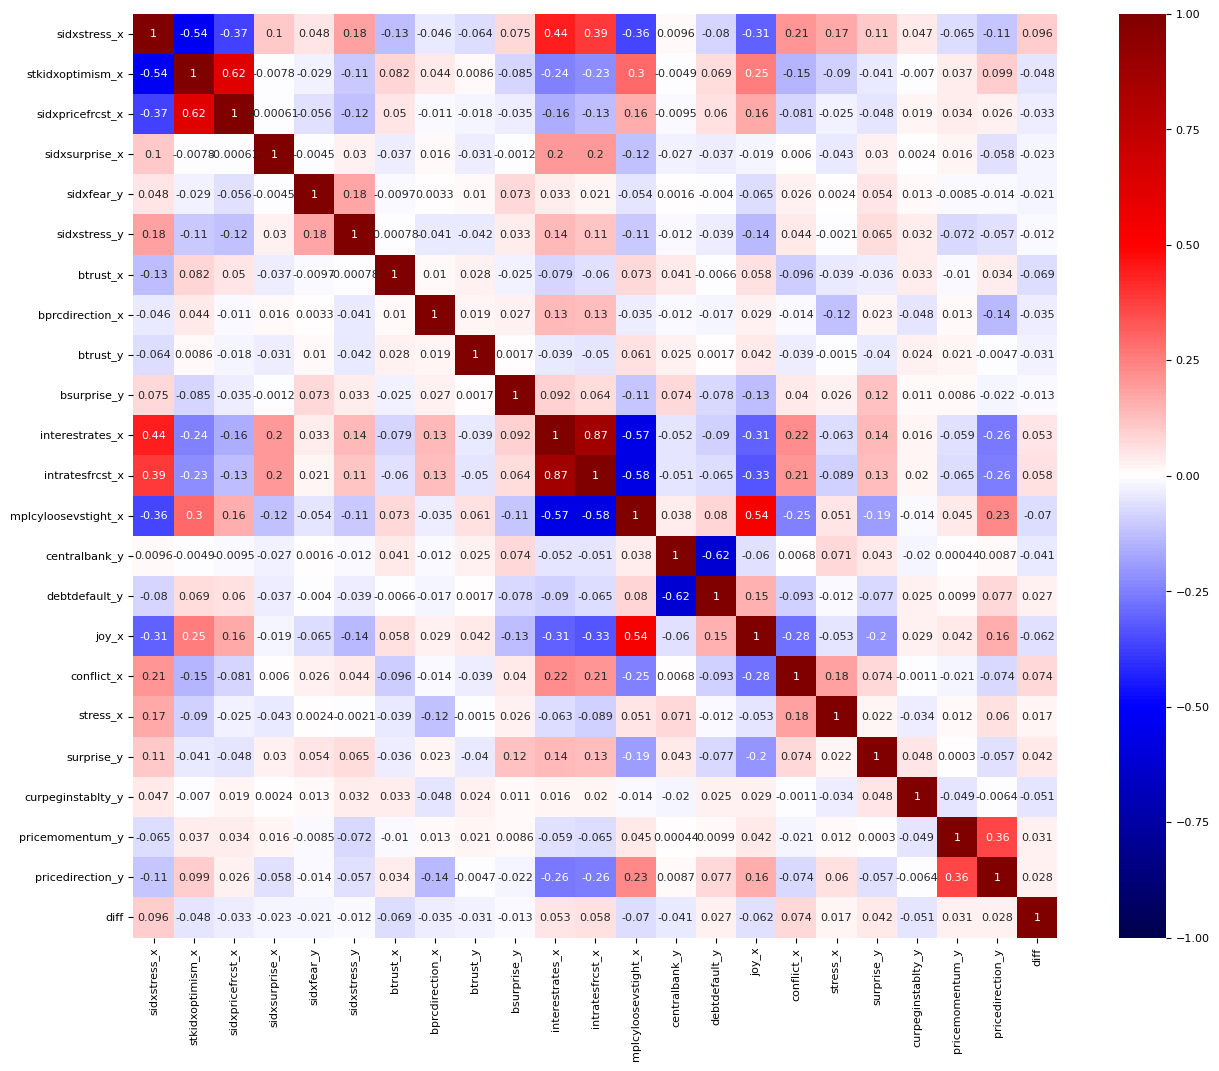

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
test_cols = stockindex_cols + bond_cols + rates_cols + currency_cols + ['diff']
curr_data_0 =df_1H[test_cols]

#curr_data_1 =df_1H.loc[df_1H.utc_datetime <'2021'][test_cols]
#curr_data_2 =df_1H.loc[df_1H.utc_datetime >'2021'][df_1H.utc_datetime <'2023'][test_cols]
#curr_data_3 =df_1H.loc[df_1H.utc_datetime >'2023'][test_cols]


corr_0 = curr_data_0.corr(method='spearman')  # 相関行列の計算
# 相関行列のヒートマップ (相関係数の値あり)
plt.rcParams['font.size'] = 8
plt.figure(figsize=(16, 12))  # この段階で画像のサイズを指定する

sns.heatmap(corr_0, vmax=1, vmin=-1, cmap='seismic', square=True, annot=True, xticklabels=1, yticklabels=1)
plt.xlim([0, corr_0.shape[0]])
plt.show()

In [ ]:


result = pd.DataFrame(columns = ['feature','number of features', 'train acc','validation acc','test acc','F score','random seed', 'best_feature','features'])
test_cols = {
             "stockindex": stockindex_cols,
             "bond": bond_cols,
             "rates": rates_cols,
             "currency": currency_cols,
             "high_corr": high_corr_cols,
             "stockindex_bond": stockindex_cols + bond_cols,
             "stockindex_rates": stockindex_cols + rates_cols,
             "stockindex_currency": stockindex_cols + currency_cols,
             "bond_rates": bond_cols + rates_cols,
             "bond_currency": bond_cols + currency_cols,
             "rates_currency": rates_cols + currency_cols,
             "stockindex_bond_rates": stockindex_cols + bond_cols + rates_cols,
             "stockindex_bond_currency": stockindex_cols + bond_cols + currency_cols,
             "stockindex_rates_currency": stockindex_cols + rates_cols + currency_cols,
             "bond_rates_currency": bond_cols + rates_cols + currency_cols,
             "stockindex_bond_rates_currency": stockindex_cols + bond_cols + rates_cols + currency_cols

            }
for i in range(12):
    for k, v in test_cols.items():
        feature_cols = v
        cols = no_feature_cols + feature_cols

        df = df_1H[cols]
        df_train = df[ df['utc_datetime']<'2022-07']
        df_val = df[(df['utc_datetime']>'2022-07') & (df['utc_datetime']<'2023')]

        df_test = df[(df['utc_datetime']>'2023') & (df['utc_datetime']<'2023-09')]
        X_train=df_train.drop(columns=no_feature_cols)
        y_train=df_train['label']

        X_val=df_val.drop(columns=no_feature_cols)
        y_val=df_val['label']


        X_test=df_test.drop(columns=no_feature_cols)
        y_test=df_test['label']

        model_result = trainGbdt(X_train, X_val, y_train, y_val)

        y_pred_train = model_result.predict(X_train, num_iteration=model_result.best_iteration)
        y_pred_val = model_result.predict(X_val, num_iteration=model_result.best_iteration)
        y_pred_test = model_result.predict(X_test, num_iteration=model_result.best_iteration)

        new_row = {'feature': k,
               'number of features': len(v),
               'train acc': accuracy_score(y_train, np.round(y_pred_train)),
               'validation acc': accuracy_score(y_val, np.round(y_pred_val)),
               'test acc': accuracy_score(y_test, np.round(y_pred_test)),
               'F score': f1_score(y_test, np.round(y_pred_test)),
               'random seed': "rand",
               'best_feature': feature_cols[np.argmax(model_result.feature_importance(importance_type='gain'))],
               'features': feature_cols}
        result.loc[len(result)] = new_row

result = result.sort_values(['feature', 'test acc'], ascending = [True, False])

result.to_csv(currencypair +'_news_' +news_freq+ '_test_v3.csv', index=False, encoding = 'utf-8-sig')
files.download(currencypair+'_news_' +news_freq+ '_test_v3.csv')



[I 2024-02-07 14:22:03,391] A new study created in memory with name: no-name-deacde78-bbc7-422c-aa9d-d7209b0d662f
min_child_samples, val_score: 0.559801: 100%|##########| 5/5 [00:02<00:00,  2.22it/s]
[I 2024-02-07 14:22:58,104] A new study created in memory with name: no-name-ef68ec8e-52d3-407a-9630-e43b9ac93ad3


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5598014888337469)])})


min_child_samples, val_score: 0.576840: 100%|##########| 5/5 [00:02<00:00,  2.39it/s]
[I 2024-02-07 14:23:32,686] A new study created in memory with name: no-name-d22be966-bdf7-4fe1-be06-6b7bf8631539


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 7, 'feature_fraction': 0.5, 'bagging_fraction': 0.4299417207982491, 'bagging_freq': 5, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8228812358276644)]), 'val': OrderedDict([('auc', 0.5768403639371381)])})


min_child_samples, val_score: 0.565757: 100%|##########| 5/5 [00:01<00:00,  3.59it/s]
[I 2024-02-07 14:23:58,503] A new study created in memory with name: no-name-75cc7cbf-b736-467b-9bc4-fd9522e7780f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9483718103301588, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7202718388942879)]), 'val': OrderedDict([('auc', 0.56575682382134)])})


min_child_samples, val_score: 0.570389: 100%|##########| 5/5 [00:01<00:00,  3.24it/s]
[I 2024-02-07 14:24:29,158] A new study created in memory with name: no-name-fa54ab44-1992-4af1-a289-ec1039b9c033


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.110902284075867, 'lambda_l2': 2.1245654922728963, 'num_leaves': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.997973902004383, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6042307796134326)]), 'val': OrderedDict([('auc', 0.5703887510339123)])})


min_child_samples, val_score: 0.488834: 100%|##########| 5/5 [00:01<00:00,  2.60it/s]
[I 2024-02-07 14:25:04,562] A new study created in memory with name: no-name-03afc29e-0c75-41b8-863c-384a9680857a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 0.9910238550555266, 'bagging_freq': 4, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9697555609545405)]), 'val': OrderedDict([('auc', 0.48883374689826303)])})


min_child_samples, val_score: 0.544086: 100%|##########| 5/5 [00:05<00:00,  1.09s/it]
[I 2024-02-07 14:25:59,894] A new study created in memory with name: no-name-d0541387-78cf-45f2-b36a-57028eae44ab


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.386741769997302e-06, 'lambda_l2': 0.07236493369746415, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 0.6773050808911447, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5440860215053763)])})


min_child_samples, val_score: 0.526055: 100%|##########| 5/5 [00:02<00:00,  1.81it/s]
[I 2024-02-07 14:26:40,873] A new study created in memory with name: no-name-da9dfa2d-bafc-4efe-a29c-caf8623d0de0


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.575151031830555e-06, 'lambda_l2': 1.214976212879897e-06, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5260545905707196)])})


min_child_samples, val_score: 0.486849: 100%|##########| 5/5 [00:04<00:00,  1.25it/s]
[I 2024-02-07 14:27:36,596] A new study created in memory with name: no-name-9d48f34a-02cc-453b-a7a8-f6e7b6b96838


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0032723771857840664, 'lambda_l2': 3.8003658996706036e-08, 'num_leaves': 20, 'feature_fraction': 0.6, 'bagging_fraction': 0.9087104546731135, 'bagging_freq': 7, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9999932512687615)]), 'val': OrderedDict([('auc', 0.486848635235732)])})


min_child_samples, val_score: 0.550207: 100%|##########| 5/5 [00:03<00:00,  1.51it/s]
[I 2024-02-07 14:28:24,758] A new study created in memory with name: no-name-fda715f0-20b7-4fb9-bab8-251530c4727c


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.3791141559257762e-07, 'lambda_l2': 0.0012735353610217723, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.550206782464847)])})


min_child_samples, val_score: 0.594045: 100%|##########| 5/5 [00:01<00:00,  3.72it/s]
[I 2024-02-07 14:29:08,892] A new study created in memory with name: no-name-9bda9ebd-a6ad-4b26-9385-3b916fa6f209


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.211039177350528, 'lambda_l2': 1.0445597029531668e-07, 'num_leaves': 23, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7515657056473383)]), 'val': OrderedDict([('auc', 0.5940446650124069)])})


min_child_samples, val_score: 0.582630: 100%|##########| 5/5 [00:03<00:00,  1.44it/s]
[I 2024-02-07 14:29:43,439] A new study created in memory with name: no-name-4d74859d-543c-40d9-a2bf-719663c2026f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.919485405431164, 'lambda_l2': 9.610038503429378, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.8033126426413674, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6680704027642803)]), 'val': OrderedDict([('auc', 0.5826302729528536)])})


min_child_samples, val_score: 0.527709: 100%|##########| 5/5 [00:04<00:00,  1.24it/s]
[I 2024-02-07 14:30:42,147] A new study created in memory with name: no-name-1e263bb0-aa2d-4d3d-9519-dc1372ccbe2b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.9615534290410696e-05, 'lambda_l2': 8.850693841954308e-06, 'num_leaves': 17, 'feature_fraction': 0.6, 'bagging_fraction': 0.6672013017005987, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5277088502894954)])})


min_child_samples, val_score: 0.538792: 100%|##########| 5/5 [00:06<00:00,  1.20s/it]
[I 2024-02-07 14:31:47,887] A new study created in memory with name: no-name-50e4d501-5710-490d-be04-8ea990b16316


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.3050866506620934e-05, 'lambda_l2': 0.0002506377897396799, 'num_leaves': 13, 'feature_fraction': 0.948, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5387923904052936)])})


min_child_samples, val_score: 0.578825: 100%|##########| 5/5 [00:03<00:00,  1.40it/s]
[I 2024-02-07 14:32:24,819] A new study created in memory with name: no-name-08c63572-5f12-4f69-8e7d-e4ece9951ff3


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.52, 'bagging_fraction': 0.5611636095565817, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8336269031422092)]), 'val': OrderedDict([('auc', 0.5788254755996691)])})


min_child_samples, val_score: 0.573532: 100%|##########| 5/5 [00:01<00:00,  2.74it/s]
[I 2024-02-07 14:32:58,450] A new study created in memory with name: no-name-ed3e4a45-95c4-42d7-b67f-5ac2251a8270


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.361989871177643, 'lambda_l2': 0.011931907235677339, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.8454106083687214, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6996409674981103)]), 'val': OrderedDict([('auc', 0.5735318444995864)])})


min_child_samples, val_score: 0.575517: 100%|##########| 5/5 [00:01<00:00,  2.74it/s]
[I 2024-02-07 14:33:34,424] A new study created in memory with name: no-name-485661e5-5328-4f7c-9981-3fd3f48ff89b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.751899795118824, 'lambda_l2': 6.736214735935835e-06, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.4077957900242133, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7395968307958104)]), 'val': OrderedDict([('auc', 0.5755169561621174)])})


min_child_samples, val_score: 0.540281: 100%|##########| 5/5 [00:02<00:00,  1.79it/s]
[I 2024-02-07 14:34:13,450] A new study created in memory with name: no-name-083cae72-0603-47c3-adb4-c632b2091e0b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.298001790992451e-06, 'lambda_l2': 2.6163890531106434e-05, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.8521730247029299, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5402812241521919)])})


min_child_samples, val_score: 0.567246: 100%|##########| 5/5 [00:01<00:00,  2.57it/s]
[I 2024-02-07 14:34:46,523] A new study created in memory with name: no-name-6667bf2a-c666-457b-a2cb-1f82ed15cec3


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.47786704309557204, 'lambda_l2': 0.009939553604639186, 'num_leaves': 4, 'feature_fraction': 0.6, 'bagging_fraction': 0.44893603941043975, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8332995896771407)]), 'val': OrderedDict([('auc', 0.5672456575682382)])})


min_child_samples, val_score: 0.570554: 100%|##########| 5/5 [00:01<00:00,  3.20it/s]
[I 2024-02-07 14:35:13,139] A new study created in memory with name: no-name-e7df4371-29bd-4e69-8004-1038f13907ae


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.01834747809202538, 'lambda_l2': 2.5141508864296582e-06, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.6551465876021508, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7424346722816111)]), 'val': OrderedDict([('auc', 0.5705541770057899)])})


min_child_samples, val_score: 0.570306: 100%|##########| 5/5 [00:03<00:00,  1.50it/s]
[I 2024-02-07 14:35:44,128] A new study created in memory with name: no-name-c2aa2b2b-cf09-4d5d-b0d9-d0ba3648982d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.6314332248339594, 'lambda_l2': 9.424138268517941, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6667510258071483)]), 'val': OrderedDict([('auc', 0.5703060380479735)])})


min_child_samples, val_score: 0.493466: 100%|##########| 5/5 [00:01<00:00,  2.55it/s]
[I 2024-02-07 14:36:17,872] A new study created in memory with name: no-name-4cd5676a-8ed2-4cbb-bdfb-170a5a12bb40


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.007751421381726031, 'lambda_l2': 6.12627179575356e-06, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9700187614728432)]), 'val': OrderedDict([('auc', 0.4934656741108354)])})


min_child_samples, val_score: 0.567246: 100%|##########| 5/5 [00:02<00:00,  2.07it/s]
[I 2024-02-07 14:37:06,081] A new study created in memory with name: no-name-3185a678-8c3c-43a8-a0c4-dafccf7c8ea8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1962686980042685, 'lambda_l2': 1.633730782129929e-07, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5672456575682382)])})


min_child_samples, val_score: 0.560298: 100%|##########| 5/5 [00:03<00:00,  1.47it/s]
[I 2024-02-07 14:37:36,582] A new study created in memory with name: no-name-ca707fe9-a731-468c-b61f-af2273e4a614


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.08745799666049474, 'lambda_l2': 0.007131881679722228, 'num_leaves': 2, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 0.7670475547222807, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7937385271568945)]), 'val': OrderedDict([('auc', 0.5602977667493797)])})


min_child_samples, val_score: 0.547312: 100%|##########| 5/5 [00:01<00:00,  2.90it/s]
[I 2024-02-07 14:38:09,237] A new study created in memory with name: no-name-65ee7534-1ae2-4e99-81ea-a71587d2ee37


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.99050869625007, 'lambda_l2': 1.2252654716205906e-08, 'num_leaves': 2, 'feature_fraction': 0.552, 'bagging_fraction': 0.9795869610064585, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6409202569916855)]), 'val': OrderedDict([('auc', 0.5473118279569893)])})


min_child_samples, val_score: 0.549876: 100%|##########| 5/5 [00:03<00:00,  1.49it/s]
[I 2024-02-07 14:38:59,978] A new study created in memory with name: no-name-4ec7784f-5770-4cfa-bd8a-48684ca8af04


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0004883136554412564, 'lambda_l2': 4.990466647304484e-07, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.5565078345561959, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5498759305210918)])})


min_child_samples, val_score: 0.548553: 100%|##########| 5/5 [00:04<00:00,  1.16it/s]
[I 2024-02-07 14:39:56,018] A new study created in memory with name: no-name-6aaf555b-8b13-4072-8d2c-ff0ddf4e6066


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.3304954677456206, 'lambda_l2': 1.192043729680709e-07, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.4062319922858043, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5485525227460711)])})


min_child_samples, val_score: 0.604963: 100%|##########| 5/5 [00:01<00:00,  2.78it/s]
[I 2024-02-07 14:40:32,188] A new study created in memory with name: no-name-380bd0f4-bd44-4809-96b7-f5ab21796dd4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.7861329058961424, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8087780747219523)]), 'val': OrderedDict([('auc', 0.6049627791563276)])})


min_child_samples, val_score: 0.588751: 100%|##########| 5/5 [00:03<00:00,  1.44it/s]
[I 2024-02-07 14:41:07,926] A new study created in memory with name: no-name-a236a9e2-b388-4836-92a3-42a0e81e81b2


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.4064302940557703, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8346358384623691)]), 'val': OrderedDict([('auc', 0.5887510339123242)])})


min_child_samples, val_score: 0.552357: 100%|##########| 5/5 [00:04<00:00,  1.08it/s]
[I 2024-02-07 14:42:14,668] A new study created in memory with name: no-name-ccad02e2-fc88-48f2-ad49-db897c703cc6


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.2128606599055075e-08, 'lambda_l2': 1.587884681620267e-05, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5523573200992555)])})


min_child_samples, val_score: 0.577337: 100%|##########| 5/5 [00:01<00:00,  2.68it/s]
[I 2024-02-07 14:42:52,287] A new study created in memory with name: no-name-16340fdb-5435-495e-812d-33eeb0701bcd


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9511528913172875, 'bagging_freq': 7, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8217491361624014)]), 'val': OrderedDict([('auc', 0.5773366418527709)])})


min_child_samples, val_score: 0.587097: 100%|##########| 5/5 [00:01<00:00,  2.51it/s]
[I 2024-02-07 14:43:29,289] A new study created in memory with name: no-name-89191689-58d9-4f16-97cf-b17886edd1ee


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00021011905285655156, 'lambda_l2': 7.943861302241153, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.4298324966559177, 'bagging_freq': 1, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7638888888888888)]), 'val': OrderedDict([('auc', 0.5870967741935483)])})


min_child_samples, val_score: 0.576840: 100%|##########| 5/5 [00:02<00:00,  2.45it/s]
[I 2024-02-07 14:44:06,599] A new study created in memory with name: no-name-38cec724-e058-4cd8-9baa-cad2ded26cd0


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.222336281861365, 'lambda_l2': 9.71729642967225e-05, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.6441988308217419, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7629271946873988)]), 'val': OrderedDict([('auc', 0.5768403639371381)])})


min_child_samples, val_score: 0.543755: 100%|##########| 5/5 [00:02<00:00,  1.77it/s]
[I 2024-02-07 14:44:47,152] A new study created in memory with name: no-name-a44c4eb9-8ccc-41e0-9bda-7ed90783263a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.11035862215991e-08, 'lambda_l2': 0.0274525960734138, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.807965703480184, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5437551695616212)])})


min_child_samples, val_score: 0.574524: 100%|##########| 5/5 [00:01<00:00,  2.60it/s]
[I 2024-02-07 14:45:19,663] A new study created in memory with name: no-name-ce18eb2a-b6bf-451f-84b7-6ae788db4bfe


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.462439151685438, 'lambda_l2': 0.0008853986823008903, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.8113224433630529, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7189828312277292)]), 'val': OrderedDict([('auc', 0.574524400330852)])})


min_child_samples, val_score: 0.555500: 100%|##########| 5/5 [00:01<00:00,  3.09it/s]
[I 2024-02-07 14:45:46,781] A new study created in memory with name: no-name-ad1416fc-7228-4e25-bf95-aeee0cbe82b1


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9647609536956379, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7174188127632005)]), 'val': OrderedDict([('auc', 0.5555004135649297)])})


min_child_samples, val_score: 0.571216: 100%|##########| 5/5 [00:01<00:00,  2.97it/s]
[I 2024-02-07 14:46:16,424] A new study created in memory with name: no-name-2101e491-15dd-49eb-ac36-7c05bc15d0fe


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.239691301206951, 'lambda_l2': 1.2177705326754295e-08, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6029839515171148)]), 'val': OrderedDict([('auc', 0.5712158808933002)])})


min_child_samples, val_score: 0.531844: 100%|##########| 5/5 [00:01<00:00,  2.81it/s]
[I 2024-02-07 14:46:50,076] A new study created in memory with name: no-name-a133cb07-0b28-467f-8cdd-4bd2a514e45a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.3879886009329255e-06, 'lambda_l2': 0.0025470867251800315, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.41077746472117826, 'bagging_freq': 7, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7567689774322427)]), 'val': OrderedDict([('auc', 0.5318444995864351)])})


min_child_samples, val_score: 0.548222: 100%|##########| 5/5 [00:05<00:00,  1.06s/it]
[I 2024-02-07 14:47:47,051] A new study created in memory with name: no-name-e4de64d3-26ee-425b-944d-ecb58675d578


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 0.6988642503408193, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.548221670802316)])})


min_child_samples, val_score: 0.585443: 100%|##########| 5/5 [00:01<00:00,  2.58it/s]
[I 2024-02-07 14:48:28,217] A new study created in memory with name: no-name-92151cd8-d6c9-4b11-b32f-240c3a6c04a8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.4042671048800015, 'lambda_l2': 0.21353867128035234, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.45100463947094904, 'bagging_freq': 7, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9151313303099018)]), 'val': OrderedDict([('auc', 0.5854425144747726)])})


min_child_samples, val_score: 0.537469: 100%|##########| 5/5 [00:01<00:00,  2.71it/s]
[I 2024-02-07 14:49:03,958] A new study created in memory with name: no-name-af781f8e-b4c9-4bf3-a51a-e1c0b2e7dbc2


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.9907693225002929, 'bagging_freq': 7, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7808315786632113)]), 'val': OrderedDict([('auc', 0.537468982630273)])})


min_child_samples, val_score: 0.546898: 100%|##########| 5/5 [00:03<00:00,  1.50it/s]
[I 2024-02-07 14:49:53,610] A new study created in memory with name: no-name-945f8901-a35f-4250-9b08-8df56033811d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.6594547684467064e-08, 'lambda_l2': 4.7709837821670216e-05, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5468982630272953)])})


min_child_samples, val_score: 0.582299: 100%|##########| 5/5 [00:02<00:00,  2.33it/s]
[I 2024-02-07 14:50:33,191] A new study created in memory with name: no-name-61b33961-f98d-45f3-acc0-a2af24cc0f61


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.08225315196889, 'lambda_l2': 3.4866295117367e-05, 'num_leaves': 3, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.7610861439887783, 'bagging_freq': 1, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7708468307958104)]), 'val': OrderedDict([('auc', 0.5822994210090985)])})


min_child_samples, val_score: 0.570720: 100%|##########| 5/5 [00:01<00:00,  2.73it/s]
[I 2024-02-07 14:51:09,654] A new study created in memory with name: no-name-9f5846f3-2a54-49db-9018-92bb65aa3783


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.5726744304010221, 'bagging_freq': 5, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8154728161105712)]), 'val': OrderedDict([('auc', 0.5707196029776674)])})


min_child_samples, val_score: 0.573036: 100%|##########| 5/5 [00:04<00:00,  1.01it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.4226096335905167, 'lambda_l2': 3.0854128781128227e-07, 'num_leaves': 15, 'feature_fraction': 0.6, 'bagging_fraction': 0.41384767823475166, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5730355665839537)])})


[I 2024-02-07 14:52:06,851] A new study created in memory with name: no-name-d863e0d3-9564-4255-9fdc-7908635be7ce
min_child_samples, val_score: 0.552357: 100%|##########| 5/5 [00:04<00:00,  1.07it/s]
[I 2024-02-07 14:53:15,079] A new study created in memory with name: no-name-10dd9316-8060-4eac-9145-459cd0e3a2f2


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.8077652653660066e-06, 'lambda_l2': 1.0500069168583837e-05, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5523573200992555)])})


min_child_samples, val_score: 0.568734: 100%|##########| 5/5 [00:02<00:00,  2.43it/s]
[I 2024-02-07 14:53:54,076] A new study created in memory with name: no-name-039f86f4-536a-41b4-8de3-df3d45b4f328


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.9008546266193222e-08, 'lambda_l2': 8.859392295321717, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.8283847996331978, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.798482885217579)]), 'val': OrderedDict([('auc', 0.5687344913151364)])})


min_child_samples, val_score: 0.590902: 100%|##########| 5/5 [00:02<00:00,  2.40it/s]
[I 2024-02-07 14:54:32,164] A new study created in memory with name: no-name-f6c55011-e060-44e6-b804-5fec035f280b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.849531934116399, 'lambda_l2': 2.913105596480476e-07, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.40635217290770037, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.734778236691502)]), 'val': OrderedDict([('auc', 0.5909015715467328)])})


min_child_samples, val_score: 0.559471: 100%|##########| 5/5 [00:03<00:00,  1.34it/s]
[I 2024-02-07 14:55:13,295] A new study created in memory with name: no-name-1c401c82-89ab-4780-89cf-49e3ac9393ac


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.002355616504909197, 'lambda_l2': 0.0028118830146409, 'num_leaves': 2, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 0.7448819528061337, 'bagging_freq': 6, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8538461019328366)]), 'val': OrderedDict([('auc', 0.5594706368899918)])})


min_child_samples, val_score: 0.548056: 100%|##########| 5/5 [00:04<00:00,  1.17it/s]
[I 2024-02-07 14:55:52,490] A new study created in memory with name: no-name-c12bfce3-1653-4e7a-8658-045ab2aed89a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0016738119418762136, 'lambda_l2': 0.0016266156156979766, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5480562448304384)])})


min_child_samples, val_score: 0.579156: 100%|##########| 5/5 [00:02<00:00,  2.32it/s]
[I 2024-02-07 14:56:25,870] A new study created in memory with name: no-name-466aa2ee-d0dc-4683-831a-c6327d2781d8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.036781133215181e-07, 'lambda_l2': 0.13580488400718704, 'num_leaves': 4, 'feature_fraction': 0.6, 'bagging_fraction': 0.5192295838872613, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.847117616888025)]), 'val': OrderedDict([('auc', 0.5791563275434243)])})


min_child_samples, val_score: 0.564599: 100%|##########| 5/5 [00:01<00:00,  3.00it/s]
[I 2024-02-07 14:56:55,629] A new study created in memory with name: no-name-f3d8250e-4717-407d-a318-ab93286a1ba9


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.088089861072029e-08, 'lambda_l2': 0.6218785379912362, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9947706527343327, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7033460209480618)]), 'val': OrderedDict([('auc', 0.5645988420181969)])})


min_child_samples, val_score: 0.556493: 100%|##########| 5/5 [00:01<00:00,  2.90it/s]
[I 2024-02-07 14:57:27,030] A new study created in memory with name: no-name-89048d14-70fb-4853-acc3-e997c9f1a1f7


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.825070239103159, 'lambda_l2': 9.57000537859148, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 25, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6898654302991037)]), 'val': OrderedDict([('auc', 0.5564929693961952)])})


min_child_samples, val_score: 0.498759: 100%|##########| 5/5 [00:02<00:00,  2.36it/s]
[I 2024-02-07 14:58:03,969] A new study created in memory with name: no-name-383602f5-4b4a-46af-9552-7a1e9e59f667


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1719299239119611e-08, 'lambda_l2': 4.669378190113011e-05, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9687432512687615)]), 'val': OrderedDict([('auc', 0.4987593052109181)])})


min_child_samples, val_score: 0.573863: 100%|##########| 5/5 [00:05<00:00,  1.02s/it]
[I 2024-02-07 14:58:59,521] A new study created in memory with name: no-name-4667620c-d543-4da3-8cc5-3b7cedd4464a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.008535941453870027, 'lambda_l2': 0.005247085528299987, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 0.407183353403451, 'bagging_freq': 7, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5738626964433416)])})


min_child_samples, val_score: 0.555831: 100%|##########| 5/5 [00:01<00:00,  2.76it/s]
[I 2024-02-07 14:59:30,784] A new study created in memory with name: no-name-643269f7-4c38-467b-86a2-33fc467bdc29


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.534559799229434e-08, 'lambda_l2': 0.004009289116029699, 'num_leaves': 2, 'feature_fraction': 0.48000000000000004, 'bagging_fraction': 0.7355732640606716, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.796100583090379)]), 'val': OrderedDict([('auc', 0.5558312655086849)])})


min_child_samples, val_score: 0.531679: 100%|##########| 5/5 [00:02<00:00,  2.48it/s]
[I 2024-02-07 15:00:07,922] A new study created in memory with name: no-name-97200617-09df-4a45-bb6b-34703e56716f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.1042344467339775e-07, 'lambda_l2': 0.003955572372504941, 'num_leaves': 2, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.8523097161804483, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8030484019004427)]), 'val': OrderedDict([('auc', 0.5316790736145575)])})


min_child_samples, val_score: 0.546567: 100%|##########| 5/5 [00:05<00:00,  1.07s/it]
[I 2024-02-07 15:01:03,624] A new study created in memory with name: no-name-c5c7f037-d6f1-499e-bda5-5fab0df7b8a8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.468650412108404e-07, 'lambda_l2': 3.396040081420427e-05, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.5758690702457295, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5465674110835401)])})


min_child_samples, val_score: 0.564930: 100%|##########| 5/5 [00:03<00:00,  1.26it/s]
[I 2024-02-07 15:02:01,725] A new study created in memory with name: no-name-a7cf4420-bc6a-4dcf-bf20-f82b152ca061


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0002611514956629185, 'lambda_l2': 1.7465971736658542e-08, 'num_leaves': 31, 'feature_fraction': 0.852, 'bagging_fraction': 0.6495007441792439, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.564929693961952)])})


min_child_samples, val_score: 0.609926: 100%|##########| 5/5 [00:01<00:00,  2.53it/s]
[I 2024-02-07 15:02:39,717] A new study created in memory with name: no-name-a8075f7b-0e3f-4d08-8b1f-60e9d9aadd5d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.82, 'bagging_fraction': 0.7849932026898007, 'bagging_freq': 1, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8165694849368319)]), 'val': OrderedDict([('auc', 0.609925558312655)])})


min_child_samples, val_score: 0.579322: 100%|##########| 5/5 [00:02<00:00,  2.49it/s]
[I 2024-02-07 15:03:17,954] A new study created in memory with name: no-name-7cdc5627-19c4-4587-a6f2-a49865c4f9eb


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.005283176244165304, 'lambda_l2': 9.760851719849715e-06, 'num_leaves': 2, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.4067115435374302, 'bagging_freq': 7, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8185434888241011)]), 'val': OrderedDict([('auc', 0.5793217535153019)])})


min_child_samples, val_score: 0.538296: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]
[I 2024-02-07 15:04:27,289] A new study created in memory with name: no-name-ed9c67bb-8422-4eda-9353-625d384a29cb


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.668969087776772e-06, 'lambda_l2': 6.027209243579175e-06, 'num_leaves': 13, 'feature_fraction': 0.948, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5382961124896609)])})


min_child_samples, val_score: 0.579818: 100%|##########| 5/5 [00:02<00:00,  2.30it/s]
[I 2024-02-07 15:05:07,769] A new study created in memory with name: no-name-3c4dbaf2-ed01-4587-8c99-f4d27af06028


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00169924207407205, 'lambda_l2': 0.0006310738371713429, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.7421752218219685, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8414351851851852)]), 'val': OrderedDict([('auc', 0.5798180314309347)])})


min_child_samples, val_score: 0.546567: 100%|##########| 5/5 [00:02<00:00,  2.41it/s]
[I 2024-02-07 15:05:46,346] A new study created in memory with name: no-name-136095fc-764e-459c-bf89-3e333da8274c


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.58, 'bagging_fraction': 0.9902189769363673, 'bagging_freq': 7, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7469900658676168)]), 'val': OrderedDict([('auc', 0.5465674110835401)])})


min_child_samples, val_score: 0.560629: 100%|##########| 5/5 [00:03<00:00,  1.37it/s]
[I 2024-02-07 15:06:27,375] A new study created in memory with name: no-name-04333190-6b9a-465a-8f0a-52d1f20c9fe6


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.819400132220903, 'lambda_l2': 7.794104345095155e-08, 'num_leaves': 2, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 0.8330708280932526, 'bagging_freq': 5, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7573223733938019)]), 'val': OrderedDict([('auc', 0.5606286186931349)])})


min_child_samples, val_score: 0.560629: 100%|##########| 5/5 [00:03<00:00,  1.66it/s]
[I 2024-02-07 15:07:10,323] A new study created in memory with name: no-name-8e6eb69b-4558-44e4-8778-703b1b396299


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.322800367820631e-05, 'lambda_l2': 0.004643482485808489, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.7555841220608674, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5606286186931349)])})


min_child_samples, val_score: 0.578329: 100%|##########| 5/5 [00:02<00:00,  1.99it/s]
[I 2024-02-07 15:07:47,986] A new study created in memory with name: no-name-c51c80c0-c142-42c3-a45d-5f63df84acf6


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.968519366837628e-06, 'lambda_l2': 0.007409819345298622, 'num_leaves': 7, 'feature_fraction': 0.4, 'bagging_fraction': 0.6810234656852606, 'bagging_freq': 1, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7771197764820214)]), 'val': OrderedDict([('auc', 0.5783291976840363)])})


min_child_samples, val_score: 0.569231: 100%|##########| 5/5 [00:01<00:00,  2.76it/s]
[I 2024-02-07 15:08:17,466] A new study created in memory with name: no-name-b0a5d3c4-b0f8-4cce-a9a5-c26219b74211


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.312172547051218e-07, 'lambda_l2': 0.005036194217941113, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.7540515929641965, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7357365565273729)]), 'val': OrderedDict([('auc', 0.5692307692307692)])})


min_child_samples, val_score: 0.546071: 100%|##########| 5/5 [00:01<00:00,  2.76it/s]
[I 2024-02-07 15:08:51,179] A new study created in memory with name: no-name-7756d46a-7134-493d-a967-62c8584447bb


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7190047646042544)]), 'val': OrderedDict([('auc', 0.5460711331679073)])})


min_child_samples, val_score: 0.529859: 100%|##########| 5/5 [00:02<00:00,  2.09it/s]
[I 2024-02-07 15:09:30,892] A new study created in memory with name: no-name-abe7d5a0-9672-49e1-bc63-71baa7d04a28


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.569109016285187e-06, 'lambda_l2': 0.013656537157932172, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 0.41282303228811024, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9325936723895908)]), 'val': OrderedDict([('auc', 0.5298593879239041)])})


min_child_samples, val_score: 0.552688: 100%|##########| 5/5 [00:04<00:00,  1.20it/s]
[I 2024-02-07 15:10:24,747] A new study created in memory with name: no-name-14a28eee-ba0c-4fe9-b0a9-1b38454c0b40


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.2347350261444112, 'lambda_l2': 0.8043468338945582, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5526881720430108)])})


min_child_samples, val_score: 0.526055: 100%|##########| 5/5 [00:03<00:00,  1.59it/s]
[I 2024-02-07 15:11:07,731] A new study created in memory with name: no-name-aedf00e4-d073-4277-a510-02ac5a50e36b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.713623567569991e-06, 'lambda_l2': 3.507197772295952e-05, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5260545905707196)])})


min_child_samples, val_score: 0.543590: 100%|##########| 5/5 [00:02<00:00,  2.28it/s]
[I 2024-02-07 15:11:47,629] A new study created in memory with name: no-name-c91c7284-3a6d-43e5-9cbb-c973f990a10e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.527351020396095, 'lambda_l2': 6.648595404590747e-06, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.47272964245992194, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6895583630277508)]), 'val': OrderedDict([('auc', 0.5435897435897435)])})


min_child_samples, val_score: 0.546898: 100%|##########| 5/5 [00:03<00:00,  1.42it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.790239843174905e-05, 'lambda_l2': 2.2838500995168717e-07, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5468982630272953)])})


[I 2024-02-07 15:12:40,234] A new study created in memory with name: no-name-bb6b7963-2044-481c-aac5-addf1af4520b
min_child_samples, val_score: 0.588089: 100%|##########| 5/5 [00:01<00:00,  3.11it/s]
[I 2024-02-07 15:13:34,302] A new study created in memory with name: no-name-c93478b1-24cc-455c-8455-1b3b9972588b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.717324034923243, 'lambda_l2': 1.1346073479569294e-07, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.45888105677365154, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6993237771298996)]), 'val': OrderedDict([('auc', 0.5880893300248139)])})


min_child_samples, val_score: 0.593548: 100%|##########| 5/5 [00:02<00:00,  2.26it/s]
[I 2024-02-07 15:14:13,466] A new study created in memory with name: no-name-713942f2-2cf0-42d4-b323-4a6daf2086a4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.7542662335791713, 'lambda_l2': 0.059644042683477665, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.696837702736803, 'bagging_freq': 4, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8068445632221143)]), 'val': OrderedDict([('auc', 0.5935483870967742)])})


min_child_samples, val_score: 0.531844: 100%|##########| 5/5 [00:04<00:00,  1.06it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.06704147962712671, 'lambda_l2': 1.5012851807232458e-07, 'num_leaves': 15, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.6200217494376628, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5318444995864351)])})


[I 2024-02-07 15:15:17,469] A new study created in memory with name: no-name-35a5e7d9-66a1-403b-8a6c-825df5eb2829
min_child_samples, val_score: 0.547725: 100%|##########| 5/5 [00:05<00:00,  1.03s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0008488223741332003, 'lambda_l2': 3.416704659826746e-05, 'num_leaves': 13, 'feature_fraction': 0.9159999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5477253928866832)])})


[I 2024-02-07 15:16:26,335] A new study created in memory with name: no-name-aaaa5f56-0599-4f93-a107-61646c16d4a8
min_child_samples, val_score: 0.592887: 100%|##########| 5/5 [00:02<00:00,  2.24it/s]
[I 2024-02-07 15:17:09,872] A new study created in memory with name: no-name-9d39454e-7696-4678-898b-d7f5b46bddfb


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.0733197166823895e-05, 'lambda_l2': 0.29562282409420765, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.8292997240261717, 'bagging_freq': 7, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8339778371666127)]), 'val': OrderedDict([('auc', 0.5928866832092639)])})


min_child_samples, val_score: 0.555500: 100%|##########| 5/5 [00:02<00:00,  2.42it/s]
[I 2024-02-07 15:18:03,754] A new study created in memory with name: no-name-bd2f4d4b-a0be-4fa5-90ab-bc8a9f7f9088


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.677363317994216, 'lambda_l2': 3.7271132948066862e-06, 'num_leaves': 31, 'feature_fraction': 0.5, 'bagging_fraction': 0.8770342979312924, 'bagging_freq': 4, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7743426735773674)]), 'val': OrderedDict([('auc', 0.5555004135649297)])})


min_child_samples, val_score: 0.541274: 100%|##########| 5/5 [00:03<00:00,  1.41it/s]
[I 2024-02-07 15:18:46,033] A new study created in memory with name: no-name-2568cf51-cb56-496d-a1b7-f5f62a8333b9


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.4040556948588255e-06, 'lambda_l2': 0.19256058980259022, 'num_leaves': 2, 'feature_fraction': 0.48000000000000004, 'bagging_fraction': 0.9659475291477797, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8208583036389159)]), 'val': OrderedDict([('auc', 0.5412737799834574)])})


min_child_samples, val_score: 0.556658: 100%|##########| 5/5 [00:02<00:00,  1.71it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1758211854382704e-07, 'lambda_l2': 0.0004888801004675261, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5566583953680728)])})


[I 2024-02-07 15:19:29,693] A new study created in memory with name: no-name-da1a4f08-ecab-4624-80db-fec71ebac2f6
min_child_samples, val_score: 0.566749: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]
[I 2024-02-07 15:20:09,508] A new study created in memory with name: no-name-ac69937b-3589-463c-92de-cd0bc76486fe


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.4336972399688915, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8445126066299535)]), 'val': OrderedDict([('auc', 0.5667493796526054)])})


min_child_samples, val_score: 0.572870: 100%|##########| 5/5 [00:02<00:00,  2.44it/s]
[I 2024-02-07 15:20:47,883] A new study created in memory with name: no-name-8cfa5d39-1497-4cdd-a626-67bba5093714


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0001621428103414784, 'lambda_l2': 0.00047131589798249043, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.6350147602376476, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7425156570564734)]), 'val': OrderedDict([('auc', 0.5728701406120761)])})


min_child_samples, val_score: 0.571216: 100%|##########| 5/5 [00:02<00:00,  2.50it/s]
[I 2024-02-07 15:21:24,797] A new study created in memory with name: no-name-6123fd1c-eed4-4f9e-8a61-d2c075a931bc


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.249030230513806, 'lambda_l2': 8.907381624110596e-06, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6029670796890184)]), 'val': OrderedDict([('auc', 0.5712158808933002)])})


min_child_samples, val_score: 0.535732: 100%|##########| 5/5 [00:02<00:00,  2.40it/s]
[I 2024-02-07 15:22:04,739] A new study created in memory with name: no-name-6fbf6a2a-1c15-4b33-a00f-da77f1453f51


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.770004048517506, 'lambda_l2': 1.7731604863372815e-07, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6809790384407731)]), 'val': OrderedDict([('auc', 0.5357320099255584)])})


min_child_samples, val_score: 0.549876: 100%|##########| 5/5 [00:03<00:00,  1.28it/s]
[I 2024-02-07 15:23:06,803] A new study created in memory with name: no-name-61d23948-bcbf-471a-a30d-5485f81b11a2


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.151784516141242e-08, 'lambda_l2': 5.8668968691397056e-05, 'num_leaves': 25, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5498759305210918)])})


min_child_samples, val_score: 0.561456: 100%|##########| 5/5 [00:03<00:00,  1.41it/s]
[I 2024-02-07 15:23:57,609] A new study created in memory with name: no-name-7d46d1b9-99fc-487b-b463-9a141fed2ec4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.5231267648894867e-07, 'lambda_l2': 1.778626451669751e-06, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.5886993231885027, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5614557485525228)])})


min_child_samples, val_score: 0.548883: 100%|##########| 5/5 [00:02<00:00,  2.27it/s]
[I 2024-02-07 15:24:39,149] A new study created in memory with name: no-name-4ae31a14-7858-4b9b-b499-36b116df5a29


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.502300030110868, 'lambda_l2': 0.14431869631021269, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9889462680695, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6419578744196092)]), 'val': OrderedDict([('auc', 0.5488833746898263)])})


min_child_samples, val_score: 0.542432: 100%|##########| 5/5 [00:03<00:00,  1.34it/s]
[I 2024-02-07 15:25:36,212] A new study created in memory with name: no-name-254e0399-8a1e-4a53-8de4-e48cc6ae4735


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5424317617866005)])})


min_child_samples, val_score: 0.565095: 100%|##########| 5/5 [00:04<00:00,  1.11it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.848130663705416e-06, 'lambda_l2': 0.4411871207986758, 'num_leaves': 23, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.6490669421857571, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5650951199338297)])})


[I 2024-02-07 15:26:40,582] A new study created in memory with name: no-name-443b0115-f751-4ba9-9af0-0e6b6721f51e
min_child_samples, val_score: 0.618031: 100%|##########| 5/5 [00:02<00:00,  2.14it/s]
[I 2024-02-07 15:27:22,122] A new study created in memory with name: no-name-8a33dbbd-fab1-4a3c-9b76-90de7620f110


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0002459773620222587, 'lambda_l2': 1.3559289956041012e-07, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.797138886119839, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8083360328258288)]), 'val': OrderedDict([('auc', 0.6180314309346567)])})


min_child_samples, val_score: 0.586104: 100%|##########| 5/5 [00:02<00:00,  1.94it/s]
[I 2024-02-07 15:28:05,267] A new study created in memory with name: no-name-813ea8fe-b29e-466e-83e1-122125983bc2


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.020910564369915e-05, 'lambda_l2': 0.0042965310581977705, 'num_leaves': 2, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.4013675535660276, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8019753536335169)]), 'val': OrderedDict([('auc', 0.5861042183622829)])})


min_child_samples, val_score: 0.552357: 100%|##########| 5/5 [00:06<00:00,  1.34s/it]
[I 2024-02-07 15:29:19,380] A new study created in memory with name: no-name-678f54ab-aa35-483e-b106-f9585db35fb4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.246572522839648e-06, 'lambda_l2': 8.332552654589485e-06, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5523573200992555)])})


min_child_samples, val_score: 0.586104: 100%|##########| 5/5 [00:02<00:00,  2.12it/s]
[I 2024-02-07 15:30:02,203] A new study created in memory with name: no-name-892942bd-7845-49f6-b37a-dcbbd73fc868


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.8196853928158258, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8377065111758989)]), 'val': OrderedDict([('auc', 0.5861042183622829)])})


min_child_samples, val_score: 0.590240: 100%|##########| 5/5 [00:02<00:00,  2.26it/s]
[I 2024-02-07 15:30:42,932] A new study created in memory with name: no-name-e634f458-67f4-44a6-88c0-cde840e92aa6


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.955137250602897, 'lambda_l2': 6.824580772288358e-08, 'num_leaves': 2, 'feature_fraction': 0.42, 'bagging_fraction': 0.4021532190027945, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6980550156570565)]), 'val': OrderedDict([('auc', 0.5902398676592225)])})


min_child_samples, val_score: 0.556658: 100%|##########| 5/5 [00:02<00:00,  2.06it/s]
[I 2024-02-07 15:31:27,107] A new study created in memory with name: no-name-893cc5c2-2c8c-46fb-8777-dec4e5fe1eb8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.372581462132986, 'lambda_l2': 1.2701539880523876e-08, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.8252416090050967, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7617664129143721)]), 'val': OrderedDict([('auc', 0.5566583953680728)])})


min_child_samples, val_score: 0.543424: 100%|##########| 5/5 [00:04<00:00,  1.05it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.025818504737287404, 'lambda_l2': 1.0175678394107182e-08, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.5075376954561603, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9999797538062845)]), 'val': OrderedDict([('auc', 0.543424317617866)])})


[I 2024-02-07 15:32:13,756] A new study created in memory with name: no-name-bdb5f0e1-21d6-4800-9b87-7ce7f3ce86a9
min_child_samples, val_score: 0.571712: 100%|##########| 5/5 [00:02<00:00,  1.80it/s]
[I 2024-02-07 15:32:56,103] A new study created in memory with name: no-name-d577be2f-734b-43b9-8e3d-6c324100efb8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.6688502039230375, 'lambda_l2': 1.6121709541974902e-08, 'num_leaves': 7, 'feature_fraction': 0.6, 'bagging_fraction': 0.5851650571860895, 'bagging_freq': 4, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7241304259799157)]), 'val': OrderedDict([('auc', 0.571712158808933)])})


min_child_samples, val_score: 0.566088: 100%|##########| 5/5 [00:01<00:00,  2.56it/s]
[I 2024-02-07 15:33:29,642] A new study created in memory with name: no-name-fbdd9eb7-3487-466f-8695-679a2c863591


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.8250159844597997, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.732395934564302)]), 'val': OrderedDict([('auc', 0.5660876757650951)])})


min_child_samples, val_score: 0.569231: 100%|##########| 5/5 [00:03<00:00,  1.36it/s]
[I 2024-02-07 15:34:05,842] A new study created in memory with name: no-name-6147e49b-00a3-45b9-9c0d-4c033409e635


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.893227607769895, 'lambda_l2': 0.02414385296512276, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6344853417557499)]), 'val': OrderedDict([('auc', 0.5692307692307692)])})


min_child_samples, val_score: 0.550372: 100%|##########| 5/5 [00:02<00:00,  2.24it/s]
[I 2024-02-07 15:34:47,390] A new study created in memory with name: no-name-ae95ac85-0bda-45e9-b71e-0747ecc7f4a9


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.995256937687756, 'lambda_l2': 1.2730398569756732e-06, 'num_leaves': 2, 'feature_fraction': 0.45199999999999996, 'bagging_fraction': 0.7538221099989584, 'bagging_freq': 2, 'min_child_samples': 25, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.667810576611597)]), 'val': OrderedDict([('auc', 0.5503722084367245)])})


min_child_samples, val_score: 0.550538: 100%|##########| 5/5 [00:05<00:00,  1.16s/it]
[I 2024-02-07 15:35:49,021] A new study created in memory with name: no-name-72299c51-68f9-4b35-9e3f-465187cb5dff


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.1879837137926455e-07, 'lambda_l2': 9.107685284932452e-05, 'num_leaves': 25, 'feature_fraction': 0.7799999999999999, 'bagging_fraction': 0.5436926301205499, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5505376344086022)])})


min_child_samples, val_score: 0.590074: 100%|##########| 5/5 [00:03<00:00,  1.49it/s]
[I 2024-02-07 15:36:40,534] A new study created in memory with name: no-name-bff75034-8809-49ef-a89b-7d0ea25a6cdd


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.558955647472264e-05, 'lambda_l2': 0.005226530983767001, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.41377386261242205, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5900744416873449)])})


min_child_samples, val_score: 0.538296: 100%|##########| 5/5 [00:02<00:00,  2.19it/s]
[I 2024-02-07 15:37:21,565] A new study created in memory with name: no-name-70c0d04b-5e6b-4de7-b2a5-b8c8c380988a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.7271126149941989, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8036861570024836)]), 'val': OrderedDict([('auc', 0.5382961124896609)])})


min_child_samples, val_score: 0.547229: 100%|##########| 5/5 [00:04<00:00,  1.22it/s]
[I 2024-02-07 15:38:19,172] A new study created in memory with name: no-name-6cad77c9-73c8-43c3-95b2-7a658938866a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.006503577147853e-05, 'lambda_l2': 9.271356013366104e-08, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5472291149710504)])})


min_child_samples, val_score: 0.550041: 100%|##########| 5/5 [00:04<00:00,  1.21it/s]
[I 2024-02-07 15:39:22,804] A new study created in memory with name: no-name-18fe7d63-025f-4e48-9a40-947b9e63bc4c


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.4616327004468226, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5500413564929694)])})


min_child_samples, val_score: 0.587758: 100%|##########| 5/5 [00:02<00:00,  2.20it/s]
[I 2024-02-07 15:40:04,186] A new study created in memory with name: no-name-4a963b97-4309-4760-9ca3-db9017fd2a40


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.44480882003783945, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8148080660835763)]), 'val': OrderedDict([('auc', 0.5877584780810587)])})


min_child_samples, val_score: 0.508850: 100%|##########| 5/5 [00:05<00:00,  1.08s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 23, 'feature_fraction': 0.6, 'bagging_fraction': 0.9454585879914827, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5088502894954507)])})


[I 2024-02-07 15:41:15,498] A new study created in memory with name: no-name-0ac18a2c-3706-4404-8af5-317977351c1b
min_child_samples, val_score: 0.544748: 100%|##########| 5/5 [00:04<00:00,  1.09it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.8471757594095298e-06, 'lambda_l2': 8.224582162159226e-05, 'num_leaves': 9, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5447477253928866)])})


[I 2024-02-07 15:42:23,097] A new study created in memory with name: no-name-030dbbff-30ea-4574-807c-f067a1217ede
min_child_samples, val_score: 0.580314: 100%|##########| 5/5 [00:02<00:00,  2.02it/s]
[I 2024-02-07 15:43:11,022] A new study created in memory with name: no-name-1b245441-c826-4f54-930f-c046e9d4e678


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.039939087820292055, 'lambda_l2': 2.4562976533138303, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.8808625479295038, 'bagging_freq': 6, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8177775078285282)]), 'val': OrderedDict([('auc', 0.5803143093465674)])})


min_child_samples, val_score: 0.556824: 100%|##########| 5/5 [00:04<00:00,  1.22it/s]
[I 2024-02-07 15:43:55,998] A new study created in memory with name: no-name-5cd38c58-6331-45d6-85a4-47ae0c9666bf


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.613713756701843, 'lambda_l2': 1.3072501299802614e-08, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.9792223099295961, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7050669474138862)]), 'val': OrderedDict([('auc', 0.5568238213399503)])})


min_child_samples, val_score: 0.561621: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]
[I 2024-02-07 15:44:40,829] A new study created in memory with name: no-name-15728cb7-1089-4f92-9237-6b6fdfaed1b0


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.013347254233764101, 'lambda_l2': 0.0006308218701227226, 'num_leaves': 2, 'feature_fraction': 0.48000000000000004, 'bagging_fraction': 0.44855229799653873, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8494897959183674)]), 'val': OrderedDict([('auc', 0.5616211745244003)])})


min_child_samples, val_score: 0.544913: 100%|##########| 5/5 [00:03<00:00,  1.44it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.667155013098083e-05, 'lambda_l2': 1.1075692015197998e-08, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 0.7367167409665721, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5449131513647643)])})


[I 2024-02-07 15:45:30,037] A new study created in memory with name: no-name-07d9966b-72a3-44fb-ac5b-a0b21477ebce
min_child_samples, val_score: 0.569727: 100%|##########| 5/5 [00:02<00:00,  1.83it/s]
[I 2024-02-07 15:46:12,021] A new study created in memory with name: no-name-0a80490b-b4a6-426e-a149-0aefd5b142fb


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 4, 'feature_fraction': 0.5, 'bagging_fraction': 0.41350659068873763, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8363263956376201)]), 'val': OrderedDict([('auc', 0.569727047146402)])})


min_child_samples, val_score: 0.568073: 100%|##########| 5/5 [00:02<00:00,  2.23it/s]
[I 2024-02-07 15:46:47,693] A new study created in memory with name: no-name-e38fa074-b6ba-4ed5-b098-0853f144677b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.017472053801731818, 'lambda_l2': 0.059398159345266294, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9067959737384215, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7225090432998597)]), 'val': OrderedDict([('auc', 0.5680727874276261)])})


min_child_samples, val_score: 0.548553: 100%|##########| 5/5 [00:02<00:00,  2.30it/s]
[I 2024-02-07 15:47:27,157] A new study created in memory with name: no-name-cc6fd8a7-7517-406c-b1d7-f1a103945e9b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.4683434832679551e-08, 'lambda_l2': 9.474863717348507, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6751127038116834)]), 'val': OrderedDict([('auc', 0.5485525227460711)])})


min_child_samples, val_score: 0.526055: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]
[I 2024-02-07 15:48:12,937] A new study created in memory with name: no-name-09c32400-a7af-4c6f-a70b-1fd051d4910e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.656629232819304, 'lambda_l2': 2.993666264699507e-05, 'num_leaves': 3, 'feature_fraction': 0.484, 'bagging_fraction': 0.4012451952939764, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7579196361084116)]), 'val': OrderedDict([('auc', 0.5260545905707196)])})


min_child_samples, val_score: 0.577667: 100%|##########| 5/5 [00:05<00:00,  1.10s/it]
[I 2024-02-07 15:49:15,196] A new study created in memory with name: no-name-fc6bc899-91fc-4511-a0f7-848c7c897a2e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.057409167014987e-06, 'lambda_l2': 0.0004458508128454925, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.4054396559743516, 'bagging_freq': 7, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9924582928409459)]), 'val': OrderedDict([('auc', 0.577667493796526)])})


min_child_samples, val_score: 0.533333: 100%|##########| 5/5 [00:03<00:00,  1.40it/s]
[I 2024-02-07 15:50:08,071] A new study created in memory with name: no-name-4edc192f-b269-4537-8379-edc92b4000d1


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.7864627286603683, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5333333333333333)])})


min_child_samples, val_score: 0.524069: 100%|##########| 5/5 [00:02<00:00,  1.97it/s]
[I 2024-02-07 15:50:50,838] A new study created in memory with name: no-name-474f1120-3bc2-40eb-8151-f57182a9f95e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.7563691951254023, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8000384677680596)]), 'val': OrderedDict([('auc', 0.5240694789081886)])})


min_child_samples, val_score: 0.542432: 100%|##########| 5/5 [00:03<00:00,  1.29it/s]
[I 2024-02-07 15:51:50,903] A new study created in memory with name: no-name-f6749314-0595-446c-a002-a0edb19a3ce1


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5424317617866005)])})


min_child_samples, val_score: 0.553184: 100%|##########| 5/5 [00:05<00:00,  1.18s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 23, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.5527140251555471, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5531844499586435)])})


[I 2024-02-07 15:52:59,155] A new study created in memory with name: no-name-626a6fc1-35ae-4c15-8be3-f4ec899feec3
min_child_samples, val_score: 0.616377: 100%|##########| 5/5 [00:02<00:00,  2.04it/s]
[I 2024-02-07 15:53:43,424] A new study created in memory with name: no-name-91b47437-2654-493a-a154-5563e1887a14


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.7753349525398388, 'bagging_freq': 1, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8174873123852716)]), 'val': OrderedDict([('auc', 0.6163771712158809)])})


min_child_samples, val_score: 0.569396: 100%|##########| 5/5 [00:02<00:00,  1.70it/s]
[I 2024-02-07 15:54:47,415] A new study created in memory with name: no-name-dad40253-add6-4921-b61a-36faa094533e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.875286359503153, 'lambda_l2': 2.685986708331106e-08, 'num_leaves': 23, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.4021597012851252, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9282339920095022)]), 'val': OrderedDict([('auc', 0.5693961952026468)])})


min_child_samples, val_score: 0.539289: 100%|##########| 5/5 [00:02<00:00,  1.95it/s]
[I 2024-02-07 15:55:58,199] A new study created in memory with name: no-name-74c40ad9-a8cb-43bd-b4c3-703835fa4347


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.643096966677095, 'lambda_l2': 9.448905301236382, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9184078393262066)]), 'val': OrderedDict([('auc', 0.5392886683209264)])})


min_child_samples, val_score: 0.598511: 100%|##########| 5/5 [00:04<00:00,  1.16it/s]
[I 2024-02-07 15:56:46,778] A new study created in memory with name: no-name-e438a303-8532-4981-9e8c-6c95135719f7


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.5083285470641488e-05, 'lambda_l2': 0.1467865148827097, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.4089770026964039, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8260716985206781)]), 'val': OrderedDict([('auc', 0.5985111662531017)])})


min_child_samples, val_score: 0.564599: 100%|##########| 5/5 [00:02<00:00,  1.96it/s]
[I 2024-02-07 15:57:31,652] A new study created in memory with name: no-name-2216e005-3b5e-461f-9f97-180b81437fc1


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.7639981695820985, 'lambda_l2': 4.757569462849425e-08, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.8062824729785826, 'bagging_freq': 6, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7239195281287119)]), 'val': OrderedDict([('auc', 0.5645988420181969)])})


min_child_samples, val_score: 0.551199: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]
[I 2024-02-07 15:58:18,297] A new study created in memory with name: no-name-4969ae5d-e351-4fda-8f3c-75616430d7b4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.3781200196241095, 'lambda_l2': 0.00038147914385947473, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.7672894743026581, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7666727405247813)]), 'val': OrderedDict([('auc', 0.5511993382961125)])})


min_child_samples, val_score: 0.542266: 100%|##########| 5/5 [00:04<00:00,  1.03it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.555758013652227e-06, 'lambda_l2': 0.002706250570102591, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5422663358147229)])})


[I 2024-02-07 15:59:05,444] A new study created in memory with name: no-name-f8bdf52f-57ac-478c-abfe-1f9d2f28148f
min_child_samples, val_score: 0.574690: 100%|##########| 5/5 [00:02<00:00,  1.90it/s]
[I 2024-02-07 15:59:45,245] A new study created in memory with name: no-name-f8ed21b6-3d39-4b02-acfb-402e1de468b8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.5484058378645736e-06, 'lambda_l2': 0.05690257719362942, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.41578596136044493, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.826461437749703)]), 'val': OrderedDict([('auc', 0.5746898263027296)])})


min_child_samples, val_score: 0.575352: 100%|##########| 5/5 [00:03<00:00,  1.34it/s]
[I 2024-02-07 16:00:21,619] A new study created in memory with name: no-name-c53c01b6-788a-4e71-ab64-d7aecf18c2c5


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.005785792193671968, 'lambda_l2': 0.005685289302169244, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9108543224895279, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7227992387431162)]), 'val': OrderedDict([('auc', 0.5753515301902399)])})


min_child_samples, val_score: 0.567990: 100%|##########| 5/5 [00:02<00:00,  2.07it/s]
[I 2024-02-07 16:01:01,041] A new study created in memory with name: no-name-096ffb0e-7755-4fe5-8aab-145d83ecb980


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.454328763960911, 'lambda_l2': 8.198380001300972, 'num_leaves': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.9951394754009035, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6008125472411187)]), 'val': OrderedDict([('auc', 0.5679900744416874)])})


min_child_samples, val_score: 0.493797: 100%|##########| 5/5 [00:02<00:00,  1.83it/s]
[I 2024-02-07 16:01:46,390] A new study created in memory with name: no-name-78a37a33-81cc-47c1-b79c-c601a6623ddc


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.016165429247916103, 'lambda_l2': 0.003475867781116623, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 0.993787428293503, 'bagging_freq': 4, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9684024403412158)]), 'val': OrderedDict([('auc', 0.49379652605459057)])})


min_child_samples, val_score: 0.577998: 100%|##########| 5/5 [00:02<00:00,  1.99it/s]
[I 2024-02-07 16:02:44,485] A new study created in memory with name: no-name-09db294f-6629-4dbb-a358-31ff9e8bbe82


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.224168420427734, 'lambda_l2': 7.497112203989496e-08, 'num_leaves': 25, 'feature_fraction': 0.7799999999999999, 'bagging_fraction': 0.4301631163803523, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.813677653601123)]), 'val': OrderedDict([('auc', 0.5779983457402812)])})


min_child_samples, val_score: 0.566253: 100%|##########| 5/5 [00:02<00:00,  2.21it/s]
[I 2024-02-07 16:03:23,720] A new study created in memory with name: no-name-e2af43eb-484c-448b-a2b9-f7edd9fd2b53


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.7878663885086974, 'bagging_freq': 5, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8045769895259691)]), 'val': OrderedDict([('auc', 0.5662531017369727)])})


min_child_samples, val_score: 0.537634: 100%|##########| 5/5 [00:03<00:00,  1.47it/s]
[I 2024-02-07 16:04:08,951] A new study created in memory with name: no-name-045b4ca2-4a87-4d9c-8f85-d9e2436b2d9d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.263624618737213e-05, 'lambda_l2': 0.008412925126362266, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9440534066060325, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.786908811143505)]), 'val': OrderedDict([('auc', 0.5376344086021505)])})


min_child_samples, val_score: 0.548718: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.2580446721568675e-05, 'lambda_l2': 1.8160598555349338e-07, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.5912906877650635, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5487179487179488)])})


[I 2024-02-07 16:05:15,819] A new study created in memory with name: no-name-38064485-cdfd-46ec-82e5-2b351c9fdc80
min_child_samples, val_score: 0.541935: 100%|##########| 5/5 [00:05<00:00,  1.14s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 23, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5419354838709678)])})


[I 2024-02-07 16:06:19,773] A new study created in memory with name: no-name-92f506ff-15de-42ea-a494-0c83eabeb1e5
min_child_samples, val_score: 0.621009: 100%|##########| 5/5 [00:02<00:00,  1.93it/s]
[I 2024-02-07 16:07:04,554] A new study created in memory with name: no-name-1740a0d4-12ea-42a3-977f-d0c85e154932


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.82, 'bagging_fraction': 0.6153170242173827, 'bagging_freq': 2, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8227411996544649)]), 'val': OrderedDict([('auc', 0.6210090984284533)])})


min_child_samples, val_score: 0.534988: 100%|##########| 5/5 [00:04<00:00,  1.02it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.5561436598244445e-07, 'lambda_l2': 0.0037790185363121877, 'num_leaves': 23, 'feature_fraction': 0.6, 'bagging_fraction': 0.6401237294920158, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5349875930521092)])})


[I 2024-02-07 16:08:16,769] A new study created in memory with name: no-name-1a5ec164-da0d-410e-8c02-696437d3d3ac
min_child_samples, val_score: 0.558974: 100%|##########| 5/5 [00:02<00:00,  2.00it/s]
[I 2024-02-07 16:09:21,750] A new study created in memory with name: no-name-111011f5-9fea-4dd5-ad66-717c494d1b3f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.604424761988683, 'lambda_l2': 0.0010627645917696898, 'num_leaves': 9, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8835438937479754)]), 'val': OrderedDict([('auc', 0.558974358974359)])})


min_child_samples, val_score: 0.584119: 100%|##########| 5/5 [00:02<00:00,  1.85it/s]
[I 2024-02-07 16:10:10,350] A new study created in memory with name: no-name-ea03d677-44a4-4d8d-ba62-0c24ea9e8ee7


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.05112070214477097, 'lambda_l2': 0.049586037081830694, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.5691927463799585, 'bagging_freq': 2, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8448669150199762)]), 'val': OrderedDict([('auc', 0.5841191066997519)])})


min_child_samples, val_score: 0.548056: 100%|##########| 5/5 [00:02<00:00,  1.89it/s]
[I 2024-02-07 16:10:57,189] A new study created in memory with name: no-name-d36e622b-8446-4854-8e30-385d4dc93e0e


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.1144792782608656e-07, 'lambda_l2': 0.04008088559054575, 'num_leaves': 2, 'feature_fraction': 0.5, 'bagging_fraction': 0.8639665849886418, 'bagging_freq': 4, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8304010096101933)]), 'val': OrderedDict([('auc', 0.5480562448304384)])})


min_child_samples, val_score: 0.552854: 100%|##########| 5/5 [00:04<00:00,  1.17it/s]
[I 2024-02-07 16:11:45,310] A new study created in memory with name: no-name-8d1eb56b-d03d-4b66-97f5-03dc8faf2987


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0058674262956319246, 'lambda_l2': 5.906973448140867e-07, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.7602352357234848, 'bagging_freq': 1, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.797406462585034)]), 'val': OrderedDict([('auc', 0.5528535980148883)])})


min_child_samples, val_score: 0.560298: 100%|##########| 5/5 [00:05<00:00,  1.01s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.00016117699513134494, 'lambda_l2': 0.0004117628109641151, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5602977667493797)])})


[I 2024-02-07 16:12:34,300] A new study created in memory with name: no-name-babe4e7c-b082-439e-a523-a8279246e327
min_child_samples, val_score: 0.568238: 100%|##########| 5/5 [00:02<00:00,  1.83it/s]
[I 2024-02-07 16:13:17,110] A new study created in memory with name: no-name-4f9d63c0-4519-4983-9d2c-6124d223d72d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 4, 'feature_fraction': 0.5, 'bagging_fraction': 0.5838687941261915, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8493480725623582)]), 'val': OrderedDict([('auc', 0.5682382133995038)])})


min_child_samples, val_score: 0.571712: 100%|##########| 5/5 [00:02<00:00,  2.14it/s]
[I 2024-02-07 16:13:54,557] A new study created in memory with name: no-name-d477ff9a-0247-4658-a572-bf4540bade25


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.4681746545906847e-06, 'lambda_l2': 0.04348925093486417, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.8658773946385707, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.727506478781989)]), 'val': OrderedDict([('auc', 0.571712158808933)])})


min_child_samples, val_score: 0.571216: 100%|##########| 5/5 [00:02<00:00,  2.14it/s]
[I 2024-02-07 16:14:34,787] A new study created in memory with name: no-name-1a085461-5b8a-450a-9b1f-282da31c88f5


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.249911540295136, 'lambda_l2': 2.2097789122519358e-08, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.602973828420257)]), 'val': OrderedDict([('auc', 0.5712158808933002)])})


min_child_samples, val_score: 0.536725: 100%|##########| 5/5 [00:03<00:00,  1.28it/s]
[I 2024-02-07 16:15:19,908] A new study created in memory with name: no-name-61eb681c-fba1-4e49-9fdf-0f5c6a1068de


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.11484482752317, 'lambda_l2': 1.7916430093875343e-08, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6583589785120397)]), 'val': OrderedDict([('auc', 0.5367245657568238)])})


min_child_samples, val_score: 0.561125: 100%|##########| 5/5 [00:04<00:00,  1.02it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 5.289269613321344, 'lambda_l2': 1.513285441407385, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.5187691564094185, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9831315462693013)]), 'val': OrderedDict([('auc', 0.5611248966087676)])})


[I 2024-02-07 16:16:26,395] A new study created in memory with name: no-name-b34a8949-8728-4242-9bef-114eb6ef7829
min_child_samples, val_score: 0.553846: 100%|##########| 5/5 [00:05<00:00,  1.01s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1606013277280427e-05, 'lambda_l2': 3.443394792383818e-06, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.535256336955272, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5538461538461539)])})


[I 2024-02-07 16:17:25,388] A new study created in memory with name: no-name-64b09e92-f268-4e19-82c5-877e9046e99c
min_child_samples, val_score: 0.488007: 100%|##########| 5/5 [00:05<00:00,  1.13s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 11, 'feature_fraction': 0.6, 'bagging_fraction': 0.6656515101693818, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.4880066170388751)])})


[I 2024-02-07 16:18:31,462] A new study created in memory with name: no-name-00b13762-ad7c-4e2a-baa4-f718145c6951
min_child_samples, val_score: 0.553019: 100%|##########| 5/5 [00:05<00:00,  1.08s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.0230531060209e-06, 'lambda_l2': 0.006871814703261709, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.553019023986766)])})


[I 2024-02-07 16:19:32,098] A new study created in memory with name: no-name-470b1a38-847e-4a73-bbb8-f9ed5c894ba9
min_child_samples, val_score: 0.595368: 100%|##########| 5/5 [00:02<00:00,  1.95it/s]
[I 2024-02-07 16:20:28,987] A new study created in memory with name: no-name-46842933-216c-400a-a1b4-bab11587761f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.75979156731604, 'lambda_l2': 1.5046694026938143e-08, 'num_leaves': 23, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7608468982831228)]), 'val': OrderedDict([('auc', 0.5953680727874276)])})


min_child_samples, val_score: 0.582299: 100%|##########| 5/5 [00:02<00:00,  1.83it/s]
[I 2024-02-07 16:21:18,087] A new study created in memory with name: no-name-feb56917-8266-466a-8394-6488299ce0f9


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.363430954440269e-06, 'lambda_l2': 0.008911587999260511, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.4080823107294149, 'bagging_freq': 2, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8197785066407516)]), 'val': OrderedDict([('auc', 0.5822994210090985)])})


min_child_samples, val_score: 0.566088: 100%|##########| 5/5 [00:02<00:00,  1.85it/s]
[I 2024-02-07 16:22:08,362] A new study created in memory with name: no-name-f1ba0622-a75d-4010-8cc8-d5644372ee57


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.6799999999999999, 'bagging_fraction': 0.5488830739574624, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.824661213691826)]), 'val': OrderedDict([('auc', 0.5660876757650951)])})


min_child_samples, val_score: 0.552357: 100%|##########| 5/5 [00:05<00:00,  1.10s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.970379999512784e-06, 'lambda_l2': 4.113401888569286e-06, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5523573200992555)])})


[I 2024-02-07 16:23:28,874] A new study created in memory with name: no-name-dd8089cd-82d3-4d7e-88b4-03767b745f2b
min_child_samples, val_score: 0.568238: 100%|##########| 5/5 [00:02<00:00,  1.78it/s]
[I 2024-02-07 16:24:19,112] A new study created in memory with name: no-name-e575071b-e8c9-4756-8982-3e94edca2836


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.665671657852602, 'lambda_l2': 1.9270333564478281e-07, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.7979370392745386, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7237339380196524)]), 'val': OrderedDict([('auc', 0.5682382133995038)])})


min_child_samples, val_score: 0.572705: 100%|##########| 5/5 [00:02<00:00,  1.85it/s]
[I 2024-02-07 16:25:07,706] A new study created in memory with name: no-name-972113b8-1b2b-4824-b131-c60fcbd9d316


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.85896675226855e-07, 'lambda_l2': 0.19382483756538724, 'num_leaves': 2, 'feature_fraction': 0.42, 'bagging_fraction': 0.526206499839443, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.823561170499946)]), 'val': OrderedDict([('auc', 0.5727047146401986)])})


min_child_samples, val_score: 0.564103: 100%|##########| 5/5 [00:02<00:00,  1.82it/s]
[I 2024-02-07 16:25:56,138] A new study created in memory with name: no-name-645732ee-6c2c-42a4-a278-02b32851a6cc


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.010602080570961125, 'lambda_l2': 1.0728879909823444e-08, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.44378999666255076, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8432944606413995)]), 'val': OrderedDict([('auc', 0.5641025641025641)])})


min_child_samples, val_score: 0.550207: 100%|##########| 5/5 [00:03<00:00,  1.30it/s]
[I 2024-02-07 16:26:45,499] A new study created in memory with name: no-name-03821e26-cc98-4b09-ba78-8ae6977ef700


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0010034652204360106, 'lambda_l2': 0.0049236923682787785, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.550206782464847)])})


min_child_samples, val_score: 0.586600: 100%|##########| 5/5 [00:02<00:00,  1.74it/s]
[I 2024-02-07 16:27:29,186] A new study created in memory with name: no-name-cea4545d-c2cd-45db-bc8e-6c098ca7c9d0


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.06385746840213674, 'lambda_l2': 0.17939108624476205, 'num_leaves': 4, 'feature_fraction': 0.6, 'bagging_fraction': 0.4750882974489152, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8363871342187669)]), 'val': OrderedDict([('auc', 0.5866004962779157)])})


min_child_samples, val_score: 0.571050: 100%|##########| 5/5 [00:02<00:00,  2.08it/s]
[I 2024-02-07 16:28:07,705] A new study created in memory with name: no-name-352bc264-2238-4698-9873-831519fc48b8


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0025420550588278893, 'lambda_l2': 2.032939412794126e-05, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.845762852100239, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7290958049886621)]), 'val': OrderedDict([('auc', 0.5710504549214227)])})


min_child_samples, val_score: 0.572291: 100%|##########| 5/5 [00:03<00:00,  1.36it/s]
[I 2024-02-07 16:28:52,012] A new study created in memory with name: no-name-5df412bf-804e-40cf-90e4-4d78dfeca178


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 2.9743451013304014, 'lambda_l2': 0.17111009846965838, 'num_leaves': 2, 'feature_fraction': 0.7, 'bagging_fraction': 0.9964239891095288, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6680602796674225)]), 'val': OrderedDict([('auc', 0.5722911497105045)])})


min_child_samples, val_score: 0.504880: 100%|##########| 5/5 [00:02<00:00,  1.81it/s]
[I 2024-02-07 16:29:38,048] A new study created in memory with name: no-name-8c90b59e-3e05-4c4d-b870-4d13afa29854


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0002879410542461811, 'lambda_l2': 1.7269359947187765e-05, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9683855685131195)]), 'val': OrderedDict([('auc', 0.5048800661703887)])})


min_child_samples, val_score: 0.555997: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.01177459780610136, 'lambda_l2': 4.4717166658405156e-06, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.8635959194096087, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5559966914805624)])})


[I 2024-02-07 16:30:46,330] A new study created in memory with name: no-name-c5a6766c-46cf-4728-8fef-04fc0ba8695e
min_child_samples, val_score: 0.561787: 100%|##########| 5/5 [00:03<00:00,  1.39it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.4013583450988824, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5617866004962779)])})


[I 2024-02-07 16:31:40,953] A new study created in memory with name: no-name-172a36ce-c9a2-471a-94cc-63d5ac192fe9
min_child_samples, val_score: 0.544582: 100%|##########| 5/5 [00:02<00:00,  1.80it/s]
[I 2024-02-07 16:32:28,395] A new study created in memory with name: no-name-8de06168-00ff-4e09-845b-2dbe462d5d8d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.11023052615704, 'lambda_l2': 0.000946929056787633, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9677727745636913, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6527406597559658)]), 'val': OrderedDict([('auc', 0.5445822994210091)])})


min_child_samples, val_score: 0.546898: 100%|##########| 5/5 [00:05<00:00,  1.17s/it]
[I 2024-02-07 16:33:30,620] A new study created in memory with name: no-name-7c90b57b-4c58-4bcd-9fde-bc56f432a342


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.579486453125088e-08, 'lambda_l2': 0.00015313783069593746, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5468982630272953)])})


min_child_samples, val_score: 0.585608: 100%|##########| 5/5 [00:04<00:00,  1.06it/s]
[I 2024-02-07 16:34:21,278] A new study created in memory with name: no-name-2c181dc3-aa9d-4774-bbe6-7228285d8e60


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.125100890417547, 'lambda_l2': 1.9160060449883653e-08, 'num_leaves': 3, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.44017224070997757, 'bagging_freq': 1, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8062506748731239)]), 'val': OrderedDict([('auc', 0.5856079404466501)])})


min_child_samples, val_score: 0.579653: 100%|##########| 5/5 [00:04<00:00,  1.08it/s]
[I 2024-02-07 16:35:11,233] A new study created in memory with name: no-name-34a5277a-b652-4809-bd57-cb714ba93670


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 8.059098863485485, 'lambda_l2': 0.00012914920293505223, 'num_leaves': 2, 'feature_fraction': 0.9799999999999999, 'bagging_fraction': 0.4234431464864908, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7095649767843646)]), 'val': OrderedDict([('auc', 0.5796526054590571)])})


min_child_samples, val_score: 0.529859: 100%|##########| 5/5 [00:07<00:00,  1.47s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 15, 'feature_fraction': 0.6, 'bagging_fraction': 0.5643797845986619, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5298593879239041)])})


[I 2024-02-07 16:36:28,419] A new study created in memory with name: no-name-332ed3aa-091b-4e4b-9192-57ca0d26f678
min_child_samples, val_score: 0.552357: 100%|##########| 5/5 [00:07<00:00,  1.51s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1052339902939995e-08, 'lambda_l2': 6.329142329115589e-06, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5523573200992555)])})


[I 2024-02-07 16:37:55,922] A new study created in memory with name: no-name-fa72fb72-255f-4d67-bee9-94a109784a5a
min_child_samples, val_score: 0.575682: 100%|##########| 5/5 [00:02<00:00,  1.75it/s]
[I 2024-02-07 16:38:48,998] A new study created in memory with name: no-name-12d10ea8-bc41-44db-a902-8ddc759ab995


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0009263014637138487, 'lambda_l2': 0.02890011986449245, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.9261215584687085, 'bagging_freq': 1, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8293110895151712)]), 'val': OrderedDict([('auc', 0.575682382133995)])})


min_child_samples, val_score: 0.563275: 100%|##########| 5/5 [00:03<00:00,  1.65it/s]
[I 2024-02-07 16:39:41,020] A new study created in memory with name: no-name-5f106173-e0db-4853-8cf6-6db1d2021292


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.166296173918751e-08, 'lambda_l2': 4.9871475468805404e-05, 'num_leaves': 2, 'feature_fraction': 0.58, 'bagging_fraction': 0.40108712043246, 'bagging_freq': 1, 'min_child_samples': 50, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7930737771298996)]), 'val': OrderedDict([('auc', 0.5632754342431762)])})


min_child_samples, val_score: 0.553184: 100%|##########| 5/5 [00:03<00:00,  1.62it/s]
[I 2024-02-07 16:40:34,271] A new study created in memory with name: no-name-9e8221b1-d589-4f95-b293-1b4cd43def6a


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.180076303686899e-08, 'lambda_l2': 0.00394650822225715, 'num_leaves': 2, 'feature_fraction': 0.44800000000000006, 'bagging_fraction': 0.9479829621583895, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8280322049454703)]), 'val': OrderedDict([('auc', 0.5531844499586435)])})


min_child_samples, val_score: 0.548553: 100%|##########| 5/5 [00:03<00:00,  1.41it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.0036937082982179e-08, 'lambda_l2': 0.0006083080425979921, 'num_leaves': 31, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5485525227460711)])})


[I 2024-02-07 16:41:26,507] A new study created in memory with name: no-name-bb865e66-a737-485b-9b32-8a3b74134108
min_child_samples, val_score: 0.565261: 100%|##########| 5/5 [00:02<00:00,  1.72it/s]
[I 2024-02-07 16:42:13,725] A new study created in memory with name: no-name-733f2cca-54b0-43ad-b650-01f57021fd5b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 3.03927203057874e-07, 'lambda_l2': 0.010893166785164088, 'num_leaves': 3, 'feature_fraction': 0.6, 'bagging_fraction': 0.6401894417577504, 'bagging_freq': 1, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8070318405139834)]), 'val': OrderedDict([('auc', 0.5652605459057072)])})


min_child_samples, val_score: 0.562283: 100%|##########| 5/5 [00:02<00:00,  1.94it/s]
[I 2024-02-07 16:42:54,024] A new study created in memory with name: no-name-47889b6b-7e92-4530-a662-3e3a8b49a356


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.003856511799776258, 'lambda_l2': 3.156960038638048e-07, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.9938345014700269, 'bagging_freq': 4, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7053773890508584)]), 'val': OrderedDict([('auc', 0.5622828784119107)])})


min_child_samples, val_score: 0.568156: 100%|##########| 5/5 [00:03<00:00,  1.55it/s]
[I 2024-02-07 16:43:37,917] A new study created in memory with name: no-name-25c4d5d4-994f-475a-9650-9f50b634591d


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 4.384183391162848, 'lambda_l2': 9.005753149352193, 'num_leaves': 2, 'feature_fraction': 0.62, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6416221250404924)]), 'val': OrderedDict([('auc', 0.5681555004135649)])})


min_child_samples, val_score: 0.511828: 100%|##########| 5/5 [00:03<00:00,  1.66it/s]
[I 2024-02-07 16:44:26,193] A new study created in memory with name: no-name-27f52dcc-47f6-4ac6-a778-1157b768b689


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.271711591458081e-07, 'lambda_l2': 6.468838606290125e-06, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.9688478566029587)]), 'val': OrderedDict([('auc', 0.5118279569892473)])})


min_child_samples, val_score: 0.545740: 100%|##########| 5/5 [00:06<00:00,  1.27s/it]
[I 2024-02-07 16:45:36,588] A new study created in memory with name: no-name-9dedd305-ef09-4ba1-8887-fdd94562ee6c


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.6894960999977555e-06, 'lambda_l2': 0.05520504620312489, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.586517315407024, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5457402812241522)])})


min_child_samples, val_score: 0.540778: 100%|##########| 5/5 [00:05<00:00,  1.13s/it]
[I 2024-02-07 16:46:36,974] A new study created in memory with name: no-name-de2868ef-9116-454b-b082-001e2879d32b


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 14, 'feature_fraction': 0.4, 'bagging_fraction': 0.7000995188294463, 'bagging_freq': 3, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5407775020678246)])})


min_child_samples, val_score: 0.550786: 100%|##########| 5/5 [00:02<00:00,  1.78it/s]
[I 2024-02-07 16:47:23,934] A new study created in memory with name: no-name-a88f60d5-9976-472a-a7ef-28976ef89af4


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 9.95424056575353, 'lambda_l2': 1.0474073385638196e-08, 'num_leaves': 2, 'feature_fraction': 0.6, 'bagging_fraction': 0.9902629168727551, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.6385025240254832)]), 'val': OrderedDict([('auc', 0.5507857733664185)])})


min_child_samples, val_score: 0.546898: 100%|##########| 5/5 [00:04<00:00,  1.13it/s]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.1108019379345015e-06, 'lambda_l2': 9.142342297523479e-05, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5468982630272953)])})


[I 2024-02-07 16:48:27,715] A new study created in memory with name: no-name-5b2c8809-69e2-4b93-ba70-9bc2abcd96dc
min_child_samples, val_score: 0.591563: 100%|##########| 5/5 [00:02<00:00,  1.89it/s]
[I 2024-02-07 16:49:30,258] A new study created in memory with name: no-name-9fbd76c0-062c-4384-aa96-6644488e7cb5


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 7.552902517487825, 'lambda_l2': 1.0331757701853765e-08, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7993433484504913)]), 'val': OrderedDict([('auc', 0.5915632754342431)])})


min_child_samples, val_score: 0.586104: 100%|##########| 5/5 [00:04<00:00,  1.25it/s]
[I 2024-02-07 16:50:24,061] A new study created in memory with name: no-name-9f5dd1e5-fdb7-4127-b859-724c94e2cd66


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 2, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.5583790127218682, 'bagging_freq': 6, 'min_child_samples': 10, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.814177059712774)]), 'val': OrderedDict([('auc', 0.5861042183622829)])})


min_child_samples, val_score: 0.525062: 100%|##########| 5/5 [00:06<00:00,  1.37s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.9881133404238666e-08, 'lambda_l2': 0.0001053118623107458, 'num_leaves': 15, 'feature_fraction': 0.6, 'bagging_fraction': 0.7330652645694652, 'bagging_freq': 5, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5250620347394541)])})


[I 2024-02-07 16:51:42,545] A new study created in memory with name: no-name-86af7d03-335e-4ef3-bf24-b0293cad51fa
min_child_samples, val_score: 0.540612: 100%|##########| 5/5 [00:06<00:00,  1.26s/it]


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 9, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 1.0)]), 'val': OrderedDict([('auc', 0.5406120760959471)])})


[I 2024-02-07 16:52:58,093] A new study created in memory with name: no-name-a7922120-e88c-4dd5-97d7-675bc252bd6e
min_child_samples, val_score: 0.642184: 100%|##########| 5/5 [00:04<00:00,  1.20it/s]
[I 2024-02-07 16:53:50,082] A new study created in memory with name: no-name-4ed9a185-de80-4876-b0a0-636342ac52ae


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 6.772083819307201, 'lambda_l2': 0.21457021146440391, 'num_leaves': 2, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 0.4132668204798482, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.7313363837598531)]), 'val': OrderedDict([('auc', 0.6421836228287842)])})


min_child_samples, val_score: 0.594045: 100%|##########| 5/5 [00:04<00:00,  1.13it/s]
[I 2024-02-07 16:54:41,404] A new study created in memory with name: no-name-2266190c-0996-4fe7-9b68-0d5f0e17db8f


{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 1.6461023861552023e-08, 'lambda_l2': 0.7602920417726925, 'num_leaves': 2, 'feature_fraction': 0.5479999999999999, 'bagging_fraction': 0.4576049458329377, 'bagging_freq': 2, 'min_child_samples': 20, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8194579419069214)]), 'val': OrderedDict([('auc', 0.5940446650124069)])})


min_child_samples, val_score: 0.553184: 100%|##########| 5/5 [00:04<00:00,  1.08it/s]

{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'max_depth': 5, 'verbose': -1, 'feature_pre_filter': False, 'lambda_l1': 0.0064812461595630776, 'lambda_l2': 0.0013494663501038375, 'num_leaves': 2, 'feature_fraction': 0.4, 'bagging_fraction': 0.8355856142108624, 'bagging_freq': 3, 'min_child_samples': 5, 'num_iterations': 1000} 0 defaultdict(<class 'collections.OrderedDict'>, {'train': OrderedDict([('auc', 0.8517303746895584)]), 'val': OrderedDict([('auc', 0.5531844499586435)])})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>